<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020_private/blob/main/simple_mnist_mdn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple MNIST dense net with Mixture Density Network

Using on:
https://keras.io/examples/vision/mnist_convnet/ 

## Setup

In [132]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt


## Prepare the data

In [133]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#Select 2 classes
N_CLASSES = num_classes

indices = np.where(y_train < N_CLASSES) # 3 classes only
indices = indices[0]
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

indices = np.where(y_test < N_CLASSES) # 3 classes only
indices = indices[0]
np.random.shuffle(indices)
x_test = x_test[indices]
y_test = y_test[indices]

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# **Install keras-mdn-layer**

In [134]:
! pip install keras-mdn-layer
import mdn

Parameters for MDN

In [135]:
N_HIDDEN = 256  # number of hidden units in the Dense layer
N_MIXES = 1  # number of mixture components
OUTPUT_DIMS = num_classes  # number of real-values predicted by each mixture component


## Build the model

In [136]:
model = keras.Sequential()
model.add(keras.Input(shape=input_shape))
model.add(layers.Flatten())
model.add(layers.Dense(N_HIDDEN, activation="relu"))
model.add(layers.Dense(N_HIDDEN, activation="relu"))
model.add(layers.Dense(N_HIDDEN, activation="relu"))

model.add(mdn.MDN(OUTPUT_DIMS, N_MIXES))

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_37 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_38 (Dense)             (None, 256)               65792     
_________________________________________________________________
mdn_12 (MDN)                 (None, 21)                5397      
Total params: 337,941
Trainable params: 337,941
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [137]:
batch_size = 128
epochs = 20

# This was for normal dense network
#model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES), optimizer=keras.optimizers.Adam())


model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs) #  validation_data=(x_test, y_test)) #validation_split=0.1)

Epoch 1/20
469/469 [==============================] - 3s 4ms/step - loss: -6.5068
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: -15.3975
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: -18.7776
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: -19.4916
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: -21.7180
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: -22.6283
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: -25.8800
Epoch 8/20
469/469 [==============================] - 2s 4ms/step - loss: -23.1515
Epoch 9/20
469/469 [==============================] - 2s 4ms/step - loss: -27.2995
Epoch 10/20
469/469 [==============================] - 2s 4ms/step - loss: -28.1484
Epoch 11/20
469/469 [==============================] - 2s 4ms/step - loss: -28.8538
Epoch 12/20
469/469 [==============================] - 2s 4ms/step - loss: -27.0209
Ep

# **Model prediction with MDN**

In [138]:
y_test_out = model.predict(x_test)

# y_samples - output from MDN, contains all information
y_samples = np.apply_along_axis(mdn.sample_from_output, 1, y_test_out, OUTPUT_DIMS, N_MIXES, temp=1.0)


print(x_test.shape)
print(y_test_out.shape)
print(y_samples.shape)


(10000, 28, 28, 1)
(10000, 21)
(10000, 1, 10)


In [139]:

# Split up the mixture parameters (for future fun)
# means of Gaussians
mus = y_test_out[:,:N_MIXES*OUTPUT_DIMS]
# sigmas of Gaussians
sigs = y_test_out[:,N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]
#pis = mdn.softmax(y_test_out[:,-N_MIXES:], t=1.0)


In [140]:
#print(y_samples)

#print(y_test_out)
#print(y_test[1:7])

#print(mus)
#print(sigs)


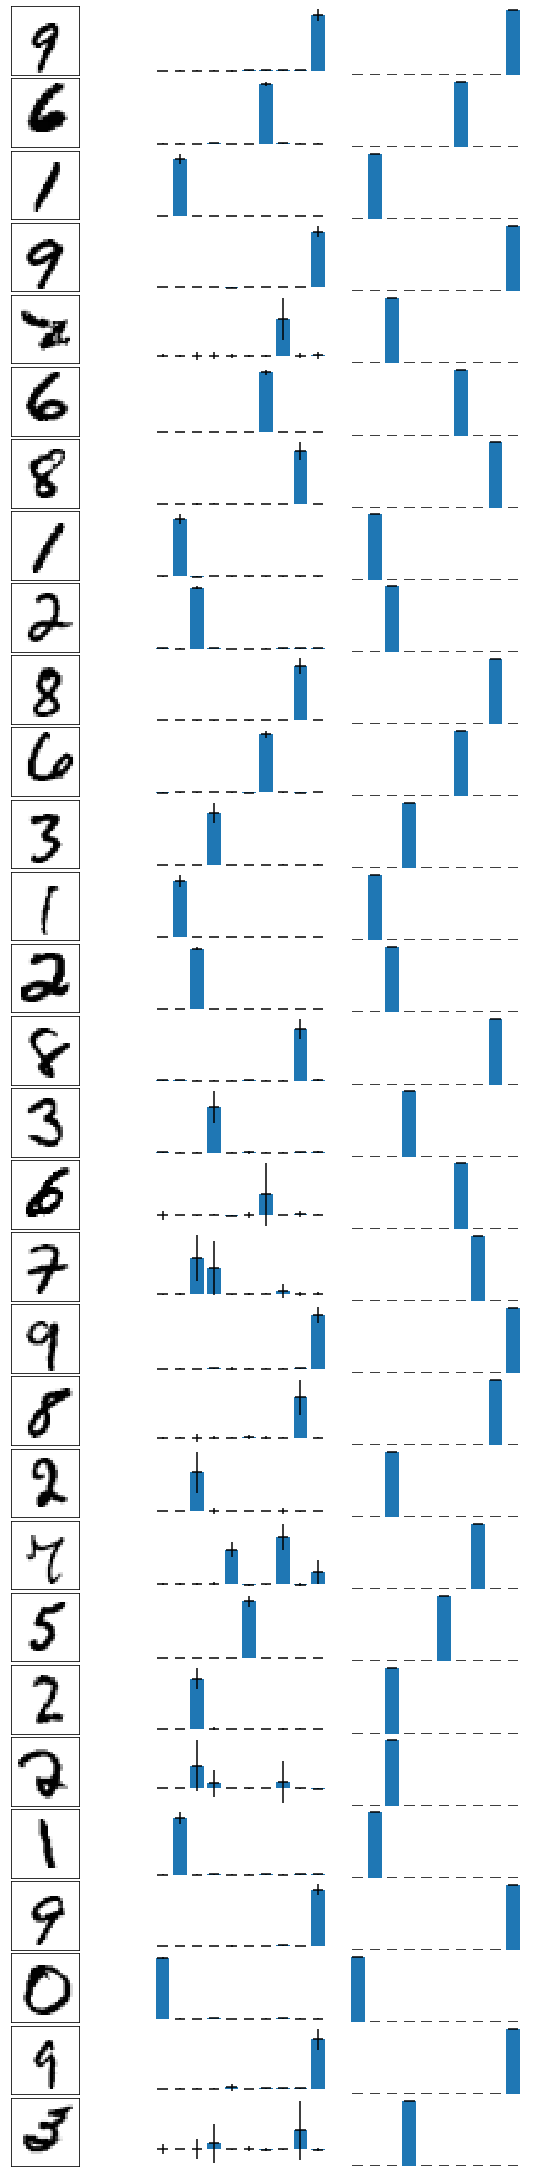

In [143]:
# use the model to predict the labels of the test data



# Plot the prediction
fig = plt.figure(figsize=(8, 30))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)


# plot the digits: each image is 28x28 pixels
n_img=30
for i in range(n_img):
    ax = fig.add_subplot(n_img, 3, 3*i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[i].reshape(28,28), cmap=plt.cm.binary, interpolation='nearest')

    ax = fig.add_subplot(n_img, 3, 3*i + 2, xticks=[0,1,2,3,4,5,6,7,8,9], yticks=[])
    xbar = np.linspace(1, OUTPUT_DIMS, num=OUTPUT_DIMS)
    ax.bar(xbar,mus[i],yerr=sigs[i],xerr=0.3,)
    ax.axis('off')

    ax = fig.add_subplot(n_img, 3, 3*i + 3, xticks=[0,1,2,3,4,5,6,7,8,9], yticks=[])
    xbar = np.linspace(1, OUTPUT_DIMS, num=OUTPUT_DIMS)
    ax.bar(xbar,y_test[i],yerr=0.0,xerr=0.3)
    ax.axis('off')

    #print(mus[i])
    #print(sigs[i])
    #print(pis[i])

    